In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import re
import string

In [3]:
# Data
pcl_data = pd.read_csv("/kaggle/input/pcl-data/dontpatronizeme_pcl.tsv", sep="\t", skiprows=4, header=None,
                         names=["par_id", "art_id", "keyword", "country_code", "text", "label"])

In [4]:
pcl_data.head()

,par_id,art_id,keyword,country_code,text,label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0
2,3,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0
4,5,@@1494111,refugee,ca,""" Just like we received migrants fleeing El Sa...",0


In [5]:
print("pcl_data:", pcl_data)

pcl_data:        par_id      art_id     keyword country_code  \
0           1  @@24942188    hopeless           ph   
1           2  @@21968160     migrant           gh   
2           3  @@16584954   immigrant           ie   
3           4   @@7811231    disabled           nz   
4           5   @@1494111     refugee           ca   
...       ...         ...         ...          ...   
10464   10465  @@14297363       women           lk   
10465   10466  @@70091353  vulnerable           ph   
10466   10467  @@20282330     in-need           ng   
10467   10468  @@16753236    hopeless           in   
10468   10469  @@16779383    homeless           ie   

                                                    text  label  
0      We 're living in times of absolute insanity , ...      0  
1      In Libya today , there are countless number of...      0  
2      White House press secretary Sean Spicer said t...      0  
3      Council customers only signs would be displaye...      0  
4      " Ju

Binary Label Counts for pcl_data:
binary_label
0    8529
1    1940
Name: count, dtype: int64


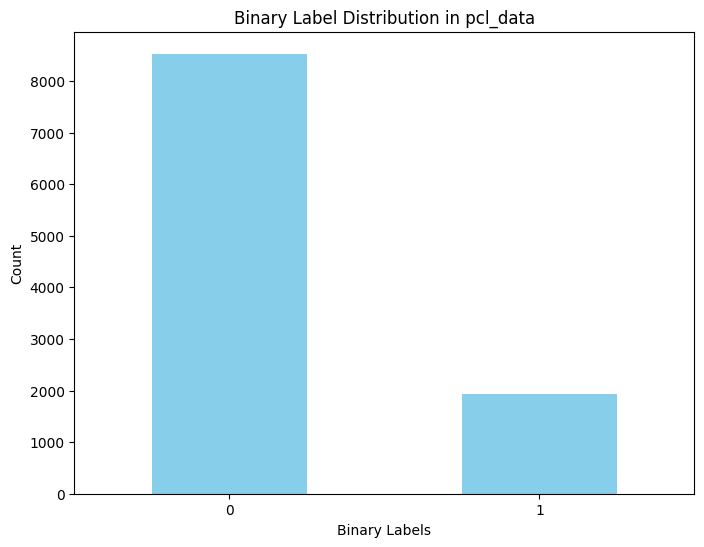

In [6]:
# Check label count
# Transform labels in pcl_data
pcl_data['binary_label'] = pcl_data['label'].apply(lambda x: 0 if x == 0 else 1)

# Label counts for pcl_data
pcl_label_counts = pcl_data['binary_label'].value_counts()
print("Binary Label Counts for pcl_data:")
print(pcl_label_counts)

# Plot for pcl_data
plt.figure(figsize=(8, 6))
pcl_label_counts.plot(kind='bar', color='skyblue')
plt.title('Binary Label Distribution in pcl_data')
plt.xlabel('Binary Labels')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Dataset is imbalanced. Hence it needs to be balanced before model training.

## Preprocessing and Data Modelling

In [8]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text

# Ensure text column is string and handle missing values
pcl_data['text'] = pcl_data['text'].fillna("").astype(str)

# Map labels for Task 1
pcl_data['binary_label'] = pcl_data['label'].apply(lambda x: 0 if x in [0, 1] else 1)

# Preprocess text
pcl_data['cleaned_text'] = pcl_data['text'].apply(preprocess_text)

# Vectorize text using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(pcl_data['cleaned_text'])
y = pcl_data['binary_label']

In [9]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

## Random Forest Model

In [11]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)
print("Random Forest (Task 1) Results:")
print(classification_report(y_test, y_pred))

Random Forest (Task 1) Results:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1926
           1       0.98      0.96      0.97      1865

    accuracy                           0.97      3791
   macro avg       0.97      0.97      0.97      3791
weighted avg       0.97      0.97      0.97      3791



## Logistic Regression Model

In [12]:
from sklearn.linear_model import LogisticRegression

# Train the classifier
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Predict on Task 1 test set
y_pred_task1 = lr.predict(X_test)

# Evaluate Task 1
print("Logistic Regression (Task 1) Results:")
print(classification_report(y_test, y_pred_task1))

Logistic Regression (Task 1) Results:
              precision    recall  f1-score   support

           0       0.95      0.88      0.92      1926
           1       0.89      0.95      0.92      1865

    accuracy                           0.92      3791
   macro avg       0.92      0.92      0.92      3791
weighted avg       0.92      0.92      0.92      3791



## LSTM

#### Before balancing the dataset:

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd


# Tokenization and padding
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(pcl_data['cleaned_text'])
X = tokenizer.texts_to_sequences(pcl_data['cleaned_text'])
X = pad_sequences(X, maxlen=128, padding='post')

# Convert labels to NumPy array for class weight computation
y = np.array(pcl_data['binary_label'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),  # Ensure it dynamically detects classes
    y=y_train
)

class_weights = dict(enumerate(class_weights))  # Convert to dictionary format



In [17]:
# Build LSTM model
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=128),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    validation_split=0.2
)


# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
print("LSTM (Task 1) Results (class_weights):")
print(classification_report(y_test, y_pred))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5361 - loss: 0.6947 - val_accuracy: 0.0890 - val_loss: 0.7688
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3253 - loss: 0.6963 - val_accuracy: 0.0890 - val_loss: 0.7515
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3325 - loss: 0.7054 - val_accuracy: 0.0890 - val_loss: 0.7233
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2506 - loss: 0.6963 - val_accuracy: 0.9075 - val_loss: 0.6719
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7043 - loss: 0.6944 - val_accuracy: 0.0907 - val_loss: 0.7276
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5297 - loss: 0.6727 - val_accuracy: 0.0907 - val_loss: 0.7728
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3047 - loss: 0.6914 - val_accuracy: 0.9033 - val_loss: 0.6677
Epoch 8/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6285 - loss: 0.7071 - val_accuracy: 0.095

#### After balancing the dataset using Focal Loss method:

In [18]:
# Using Focal Loss to handle class imbalance

import tensorflow.keras.backend as K
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, dtype=K.floatx())
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = -alpha * (1 - y_pred) ** gamma * y_true * K.log(y_pred) - \
               (1 - alpha) * y_pred ** gamma * (1 - y_true) * K.log(1 - y_pred)
        return K.mean(loss)
    return loss

model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    validation_split=0.2
)

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
print("LSTM (Task 1) Results ( Focal Loss):")
print(classification_report(y_test, y_pred))

Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8856 - loss: 0.0491 - val_accuracy: 0.9104 - val_loss: 0.0297
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9029 - loss: 0.0341 - val_accuracy: 0.9110 - val_loss: 0.0296
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9048 - loss: 0.0344 - val_accuracy: 0.9099 - val_loss: 0.0307
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9083 - loss: 0.0318 - val_accuracy: 0.9104 - val_loss: 0.0307
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9135 - loss: 0.0303 - val_accuracy: 0.9104 - val_loss: 0.0300
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9107 - loss: 0.0314 - val_accuracy: 0.9116 - val_loss: 0.0301
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9102 - loss: 0.0320 - val_accuracy: 0.9063 - val_loss: 0.0360
Epoch 8/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9170 - loss: 0.0296 - val_accu

Accuracy has increased to 90% after balancing the dataset

## BERT

In [19]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize text
X_encoded = tokenizer.batch_encode_plus(
    pcl_data['cleaned_text'].tolist(),
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'  # Use PyTorch tensors
)
y = pcl_data['binary_label'].values

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(
    X_encoded['input_ids'].numpy(),  # Convert to numpy array for SMOTE
    y
)

# Corresponding attention masks for SMOTE-balanced input IDs
attention_masks_balanced, _ = smote.fit_resample(
    X_encoded['attention_mask'].numpy(),
    y
)

In [21]:
# Train-test split
X_train, X_test, y_train, y_test, mask_train, mask_test = train_test_split(
    X_balanced,
    y_balanced,
    attention_masks_balanced,
    test_size=0.2,
    random_state=42
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.long)
attention_mask_train = torch.tensor(mask_train, dtype=torch.long)
attention_mask_test = torch.tensor(mask_test, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


In [22]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Binary classification model
class BERTBinaryClassifier(nn.Module):
    def __init__(self):
        super(BERTBinaryClassifier, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

    def forward(self, input_ids, attention_mask, labels=None):
        return self.bert(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

# Initialize model, optimizer, and loss function
model = BERTBinaryClassifier().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Convert datasets to PyTorch DataLoader
class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx],
        }

train_dataset = CustomDataset(X_train, attention_mask_train, y_train)
test_dataset = CustomDataset(X_test, attention_mask_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Training loop
epochs = 3
model.train()

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    total_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    print(f"Loss: {total_loss / len(train_loader):.4f}, Accuracy: {correct / total:.4f}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Loss: 0.1448, Accuracy: 0.9467
Epoch 2/3
Loss: 0.0870, Accuracy: 0.9674
Epoch 3/3
Loss: 0.0368, Accuracy: 0.9871


In [23]:
# Evaluation
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Metrics
print("BERT (Task 1) Results:")
print(classification_report(y_true, y_pred))


BERT (Task 1) Results:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1926
           1       0.95      0.95      0.95      1865

    accuracy                           0.95      3791
   macro avg       0.95      0.95      0.95      3791
weighted avg       0.95      0.95      0.95      3791



### Using BERT Model for prediction

## Patronizing and Condescending Language Detection System Function

In [41]:
# Sample text to test the model
sample_text = "In September , Major Nottle set off on foot from Melbourne to Canberra to plead for a national solution to the homeless problem ."

cleaned_sample_text = preprocess_text(sample_text)  

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

inputs = tokenizer(cleaned_sample_text, padding=True, truncation=True, return_tensors='pt')

input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

#Forward pass through the model
model.eval()  # Make sure the model is in evaluation mode
with torch.no_grad():  # No need to compute gradients for inference
    outputs = model(input_ids, attention_mask)
    logits = outputs.logits

# Step 4: Apply softmax to get probabilities and get the predicted label
probabilities = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
predicted_label = np.argmax(probabilities, axis=1)

# Print the prediction 
print(f"Predicted Label: {predicted_label[0]}")

if predicted_label[0] == 1:
    print("PCL text") 
else:
    print("Non PCL text ") 

Predicted Label: 1
PCL text


In [42]:
import pickle

pickle.dump(model,open("model.pkl",'wb'))
pickle.dump(tfidf,open("tfidf.pkl",'wb'))